### Pytorch LSTM Kalman Filter
###### In this implementation, we use an LSTM model to make predictions based on the input sequences. The LSTM model, being a recurrent neural network, is designed to capture temporal dependencies in time-series data. It can learn patterns and trends from the input data and make predictions accordingly. However, the LSTM model might still be sensitive to noise present in the data.

On the other hand, the Kalman Filter is a recursive estimator that is particularly suited for estimating the hidden state of a system with noisy measurements. It uses a prediction-correction cycle to iteratively refine its estimate of the system state.

By combining the LSTM model and the Kalman Filter, we aim to take advantage of both methods. The LSTM model provides initial predictions based on its learned patterns in the data, while the Kalman Filter refines these predictions by accounting for noise and the system's dynamics.

Here's a step-by-step explanation of how the integration works:

1) Train an LSTM model using the input sequences from the time-series data. This model learns to make predictions based on the patterns and trends in the data.

2) Apply the trained LSTM model to the test data, generating a sequence of predictions.

3) Create a Kalman Filter and use the training data to estimate its parameters via the Expectation-Maximization (EM) algorithm. This allows the filter to learn the dynamics and noise characteristics of the underlying system.

4) Use the Kalman Filter to refine the LSTM predictions. The filter takes the LSTM predictions as observations and updates its state estimates accordingly. This process helps to reduce the impact of noise in the LSTM predictions and smoothen the overall output.

###### In summary, the PyTorch LSTM model helps the Kalman Filter by providing initial predictions that capture the temporal dependencies in the data. The Kalman Filter then refines these predictions to create a more robust and less noisy output. This combination allows us to leverage the strengths of both methods, resulting in improved predictions for the time-series data.

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')
# Copy Lake Winnipeg's error recordings. 
!cp '/content/drive/MyDrive/Kalman_Filter/winnipeg.csv' '/content/'

Mounted at /content/drive


In [3]:
# Install pykalman if not already installed. 
!pip install pykalman

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 KB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48461 sha256=e0e0fc374e90eee5d914ac428a279883c8a0cc27236d6f9c6348dbba99f805bd
  Stored in directory: /root/.cache/pip/wheels/7a/68/21/675239322d2bb2e8e1fa317d4bd7b5566a4e82780b25a27f7a
Successfully built pykalman


In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from pykalman import KalmanFilter
import matplotlib.pyplot as plt

# Load or generate your dataset
# Assuming your dataset is a time series data with one feature
data = pd.read_csv("winnipeg.csv")
data = data.drop('Unnamed: 0', axis=1)
data = data.values.reshape(-1, 1)

# Preprocess the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Train-test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Create input and output sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length - 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 5
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

# Reshape the input for LSTM model
X_train = torch.tensor(X_train).float().view(-1, seq_length, 1)
X_test = torch.tensor(X_test).float().view(-1, seq_length, 1)
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

# Create the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        output, _ = self.lstm(x, (h0, c0))
        output = self.linear(output[:, -1, :])
        return output.squeeze()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 300
learning_rate = 0.01
scheduler_step_size = 50
scheduler_gamma = 0.1

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()


# Predict with the LSTM model
model.eval()
with torch.no_grad():
    lstm_predictions = model(X_test).numpy()

# Create the Kalman Filter
kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
kf = kf.em(train)

# Integrate the Kalman Filter with LSTM predictions
filtered_state_means, _ = kf.filter(lstm_predictions)

# Inverse transform predictions to original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions)
filtered_state_means = scaler.inverse_transform(filtered_state_means)
y_test_inv = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))




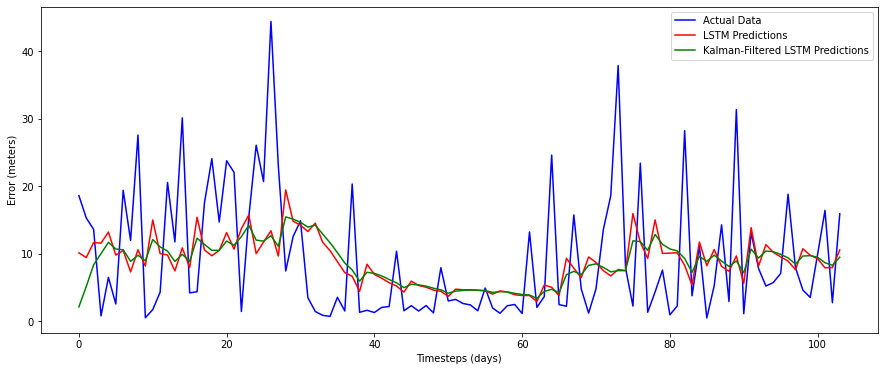

In [17]:
# Calculate the index range for the x-axis
x_range = range(104)

# Plot the results
plt.figure(figsize=(15, 6))
plt.plot(x_range, y_test_inv, label="Actual Data", color="blue")
plt.plot(x_range, lstm_predictions, label="LSTM Predictions", color="red")
plt.plot(x_range, filtered_state_means, label="Kalman-Filtered LSTM Predictions", color="green")
plt.xlabel("Timesteps (days)")
plt.ylabel("Error (meters)")
plt.legend()
plt.show()